# Installs and Configuration

In [1]:
# Install packages, set configuration as needed
# gensim, worddcloud, python-Levenshtein
# !pip install gensim

In [2]:
# Import packages
# general purpose use throughout
import numpy as np
import pandas as pd
import os
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as col
from importlib import reload
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# feature extraction/selection methods
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

# model methods
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

# custom files to keep notebook clean
import auxiliary as aux
import nlp_functions


%matplotlib inline

# Global Variables

In [3]:
# seed for random number/state generators
SEED = 421
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# the proportion of data to reserve for testing; note that the smallest class only has 13 total instances
FOLDS = 10
TEST_SIZE = 1/FOLDS

# file names
token_file = 'sentences.pkl'
ans_pkl = 'ans_01.pkl'
total_cv_pkl = 'total_cv.pkl'
class_cv_pkl = 'class_cv.pkl'
class_counts = 'class_counts.csv'
rfc_pkl = 'rfc_search_10.pkl'
rfc_model = 'rfc_model.joblib'
logreg_pkl = 'logreg_search_10.pkl'
logreg_model = 'logreg_model.joblib'
mnb_pkl = 'mnb_search_10.pkl'
mnb_model = 'mnb_model.joblib'
opt_csv = 'optimized_test_scores.csv'

# These are the columns with Yes/No Answers
YN_ANS_COLS = ['Most Favored Nation-Answer', 'Competitive Restriction Exception-Answer', 
    'Non-Compete-Answer', 'Exclusivity-Answer', 'No-Solicit Of Customers-Answer',
    'No-Solicit Of Employees-Answer', 'Non-Disparagement-Answer', 
    'Termination For Convenience-Answer', 'Rofr/Rofo/Rofn-Answer', 'Change Of Control-Answer', 
    'Anti-Assignment-Answer', 'Revenue/Profit Sharing-Answer', 'Price Restrictions-Answer', 
    'Minimum Commitment-Answer', 'Volume Restriction-Answer', 'Ip Ownership Assignment-Answer', 
    'Joint Ip Ownership-Answer', 'License Grant-Answer', 'Non-Transferable License-Answer', 
    'Affiliate License-Licensor-Answer', 'Affiliate License-Licensee-Answer', 
    'Unlimited/All-You-Can-Eat-License-Answer', 'Irrevocable Or Perpetual License-Answer', 
    'Source Code Escrow-Answer', 'Post-Termination Services-Answer', 'Audit Rights-Answer', 
    'Uncapped Liability-Answer', 'Cap On Liability-Answer', 'Liquidated Damages-Answer', 
    'Insurance-Answer', 'Covenant Not To Sue-Answer','Third Party Beneficiary-Answer']

# column names for corresponding contract text
YN_TXT_COLS = ['Most Favored Nation', 'Competitive Restriction Exception', 'Non-Compete', 
    'Exclusivity', 'No-Solicit Of Customers', 'No-Solicit Of Employees', 'Non-Disparagement', 
    'Termination For Convenience', 'Rofr/Rofo/Rofn', 'Change Of Control', 'Anti-Assignment', 
    'Revenue/Profit Sharing', 'Price Restrictions', 'Minimum Commitment', 'Volume Restriction', 
    'Ip Ownership Assignment', 'Joint Ip Ownership', 'License Grant', 'Non-Transferable License',
    'Affiliate License-Licensor', 'Affiliate License-Licensee', 'Unlimited/All-You-Can-Eat-License', 
    'Irrevocable Or Perpetual License', 'Source Code Escrow', 'Post-Termination Services',
    'Audit Rights', 'Uncapped Liability', 'Cap On Liability', 'Liquidated Damages', 'Insurance',
    'Covenant Not To Sue','Third Party Beneficiary']

# Load and Arrange Data

CUAD_v1.zip was downloaded from https://zenodo.org/record/4595826#.YJp6hqhKiUk checksum md5:c38f490a984420b8a62600db401fafd5) on 5 May 2021. The file of interest is master_clauses.csv, but I do not know of a way to access/download only this file.

In [4]:
# through manual inspection of the csv, blanks or empty data can occur in the following formats:
na_values = {'[\'[â— ]\']', '[]', '[]/[]/[]', '[\'[*]\']', '[]/[]/[][]', ''}

# read the csv, marking as null the values listed above
df_master = pd.read_csv("master_clauses.csv", header=0, na_values=na_values)
# df_master.set_index('Filename')


The first of 83 columns of the dataframe is the text filename from the corpus. Each of the other 41 labels is represented by two columns: the extracted portion of contract text relevant to that label category, and the answer to the question posed by the category. For the first 8 categories and #38 Warrant Duration, the answers are relevant dates, durations, or names. The remaining 32 answers are Yes/No to indicate whether such a clause exists in the contract. The description of each of the 41 labels can be found at https://www.atticusprojectai.org/atticus-labels.

In [5]:
# display(df_master)
display(df_master.head())
# display(df_master.info())
# df_master.columns
# df_master.shape

,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['MARKETING AFFILIATE AGREEMENT'],MARKETING AFFILIATE AGREEMENT,"['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...","Birch First Global Investments Inc. (""Company""...","['8th day of May 2014', 'May 8, 2014']",5/8/2014,['This agreement shall begin upon the date of ...,NaN,['This agreement shall begin upon the date of ...,...,NaN,No,"[""COMPANY'S SOLE AND EXCLUSIVE LIABILITY FOR T...",Yes,NaN,No,NaN,No,NaN,No
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT'],VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT,"['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...","Rogers Cable Communications Inc. (""Rogers""); E...","['July 11 , 2006']",7/11/2006,"['July 11 , 2006']",7/11/2006,"['The term of this Agreement (the ""Initial Ter...",...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['CONTENT DISTRIBUTION AND LICENSE AGREEMENT'],CONTENT DISTRIBUTION AND LICENSE AGREEMENT,"['Producer', 'Fulucai Productions Ltd.', 'Conv...","CONVERGTV, INC. (“ConvergTV”); Fulucai Product...","['November 15, 2012']",11/15/2012,"['November 15, 2012']",11/15/2012,NaN,...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,['WEBSITE CONTENT LICENSE AGREEMENT'],WEBSITE CONTENT LICENSE AGREEMENT,"['PSiTech Corporation', 'Licensor', 'Licensee'...","PSiTech Corporation (""Licensor""); Empirical Ve...","['Feb 10, 2014']",2/10/2014,"['Feb 10, 2014']",2/10/2014,['The initial term of this Agreement commences...,...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,['CONTENT LICENSE AGREEMENT'],CONTENT LICENSE AGREEMENT,"['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...",Beijing Sun Seven Stars Culture Development Li...,"['December 21, 2015']",12/21/2015,"['December 21, 2015']",12/21/2015,"['The Term of this Agreement (the ""Term"") shal...",...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No


# Preprocessing Data

Next we will process the data to prepare it for transformations.

## Separating the Text Columns into Separate 'Sentences' per Observation

Here we abandon the horizontal association of clauses in the same contract, so each clause will be its own observation (row).

In [6]:
# Creates a new dataframe with only text from each YN field
data = {'Clause' : [], 'Category':[]}
display(data)
# df_test = df_master[YN_TXT_COLS].stack().dropna().reset_index(drop=True)
# display(df_test)
df_yn_tmp = df_master[YN_TXT_COLS].replace(np.nan, '', regex=True)
# display(df_yn_tmp)
for col in YN_TXT_COLS:
    for i in range(len(df_yn_tmp[col])):
        sentence = df_yn_tmp[col].loc[i]
        if sentence:
            data['Clause'].append(sentence)
            data['Category'].append(col)
del df_yn_tmp
df_yn_tmp = pd.DataFrame(data=data, columns=['Clause', 'Category'])
display(df_yn_tmp)

{'Clause': [], 'Category': []}

,Clause,Category
0,['In the event that Licensor grants to another...,Most Favored Nation
1,"['If for any reason, Integrity and TL are subj...",Most Favored Nation
2,"[""The Company will, and Online BVI will cause ...",Most Favored Nation
3,"[""Such Prices and Volume Discount Prices shall...",Most Favored Nation
4,['All Users shall be treated at least as favor...,Most Favored Nation
...,...,...
3606,['Member hereby acknowledges and agrees that F...,Third Party Beneficiary
3607,['Lessor and Lessee expressly agree that Franc...,Third Party Beneficiary
3608,"['Except as expressly provided in Section 8, t...",Third Party Beneficiary
3609,"['Changepoint, Inc. (""Changepoint"") shall be a...",Third Party Beneficiary


## Apply Text Preprocessing to Sentences
- Remove special characters, punctuation, non-ASCII characters
- Expand contractions
- Normalize to lowercase
- Tokenization
- Lemmatization

In [7]:
if os.path.exists(token_file):
    df_yn_txt = pd.read_pickle(token_file)
#     display(df_yn_txt)
else:
    df_yn_tmp['Clean'] = df_yn_tmp.loc[:,'Clause'].apply(nlp_functions.clean_up_text)
    df_yn_tmp['Sentence'] = df_yn_tmp.loc[:,'Clean'].apply(nlp_functions.tokenize)
    # store the result in an np array of shape (510,)
    df_yn_txt = df_yn_tmp[['Sentence', 'Category']]
    df_yn_txt.to_pickle(token_file)
    print(f'{token_file} written.')
#     display(df_yn_txt)

## Text forms of x and y
Will need to convert/reduce strings to numbers for classification algorithms

In [8]:
display(df_yn_txt)
x_txt = df_yn_txt['Sentence'].squeeze()
y_txt = df_yn_txt['Category'].squeeze()

,Sentence,Category
0,"[event, licensor, grant, another, vod, pay, pe...",Most Favored Nation
1,"[reason, integrity, subject, lower, free, good...",Most Favored Nation
2,"[company, online, bvi, cause, company, use, co...",Most Favored Nation
3,"[price, volume, discount, price, shall, subjec...",Most Favored Nation
4,"[user, shall, treat, least, favorable, respect...",Most Favored Nation
...,...,...
3606,"[member, hereby, acknowledge, agree, franchiso...",Third Party Beneficiary
3607,"[lessor, lessee, expressly, agree, franchisor,...",Third Party Beneficiary
3608,"[except, expressly, provide, section, agreemen...",Third Party Beneficiary
3609,"[changepoint, inc, changepoint, shall, direct,...",Third Party Beneficiary


# Data Exploration and Visualization

## Frequency Information

In [9]:
if os.path.exists(ans_pkl):
    df_yn_ans = df_master[YN_ANS_COLS]
    df_01_ans = pd.read_pickle(ans_pkl)
else:
    # Make a new dataframe that contains only the Y/N columns
    df_yn_ans = df_master[YN_ANS_COLS]
    # display(df_yn)
    # Transform the columns to numbers
    df_01_ans = pd.DataFrame(np.where(df_yn_ans.values == 'Yes', 1, 0), df_yn_ans.index, columns=YN_TXT_COLS)
    df_01_ans.to_pickle(ans_pkl)

count     32.000000
mean     112.843750
std       85.906967
min       13.000000
25%       44.000000
50%       92.500000
75%      166.000000
max      374.000000
dtype: float64

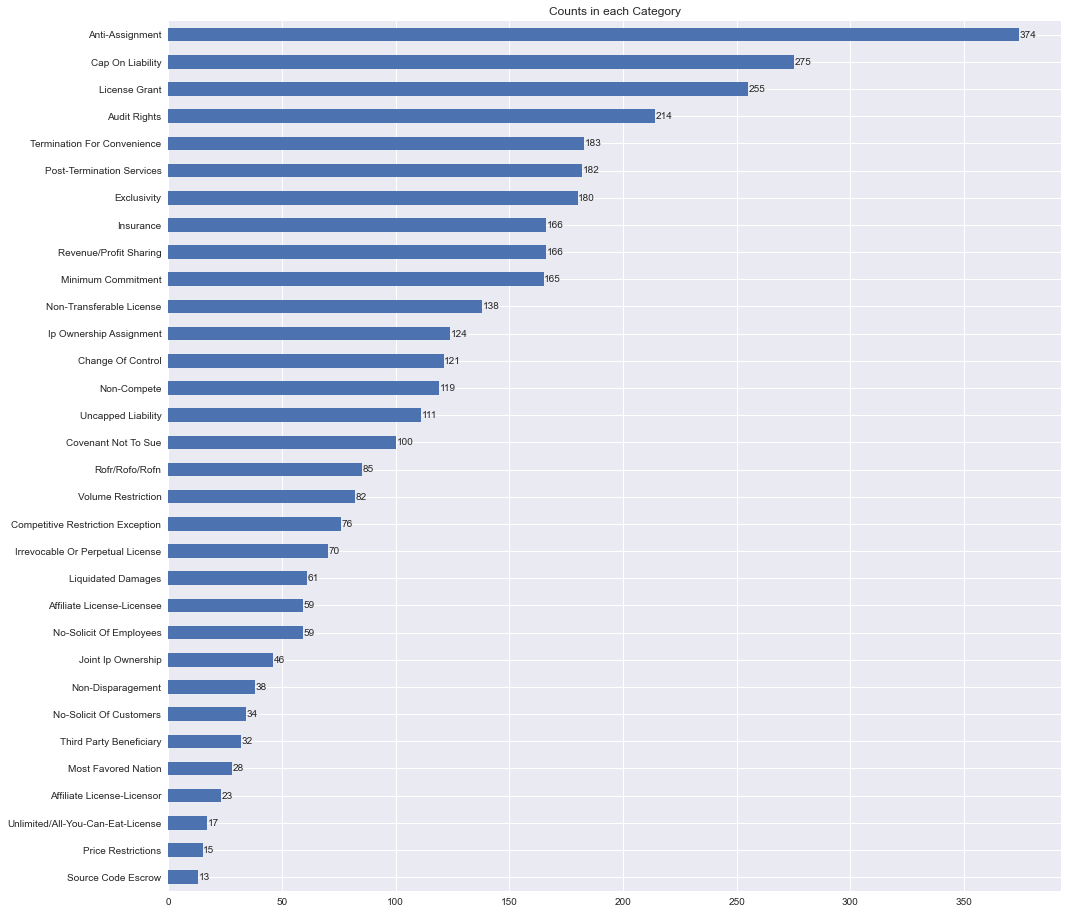

In [10]:
# print('Nonzeros (of 510 contracts) in each column')
freq = df_01_ans.astype(bool).sum(axis=0).sort_values()
# print(df_01_ans.astype(bool).sum(axis=0))
ax = freq.plot.barh(figsize=(16,16),title='Counts in each Category')
for i in range(len(freq)):
    ax.text(freq[i]+0.3, i-0.1, freq[i])
plt.savefig('class_barh.jpg')
freq.describe()

## Calculating the co-occurence (correlation) of labeled passages

In [11]:
corr = aux.correlation_views(df=df_01_ans, print_top=20, diag=-2)

,Most Favored Nation,Competitive Restriction Exception,Non-Compete,Exclusivity,No-Solicit Of Customers,No-Solicit Of Employees,Non-Disparagement,Termination For Convenience,Rofr/Rofo/Rofn,Change Of Control,Anti-Assignment,Revenue/Profit Sharing,Price Restrictions,Minimum Commitment,Volume Restriction,Ip Ownership Assignment,Joint Ip Ownership,License Grant,Non-Transferable License,Affiliate License-Licensor,Affiliate License-Licensee,Unlimited/All-You-Can-Eat-License,Irrevocable Or Perpetual License,Source Code Escrow,Post-Termination Services,Audit Rights,Uncapped Liability,Cap On Liability,Liquidated Damages,Insurance,Covenant Not To Sue,Third Party Beneficiary
Most Favored Nation,-2.00,0.02,0.05,0.15,-0.03,-0.01,-0.00,0.05,0.05,0.05,0.13,0.07,0.01,0.13,0.15,0.06,0.10,0.09,0.05,0.07,0.07,0.10,0.05,-0.04,0.11,0.11,0.06,0.12,-0.01,0.05,0.03,0.01
Competitive Restriction Exception,0.02,-2.00,0.38,0.35,0.24,0.24,0.13,-0.03,0.27,0.22,0.19,0.19,0.02,0.19,0.13,0.19,0.04,0.23,0.18,0.07,0.07,-0.05,0.06,0.07,0.19,0.21,0.15,0.14,0.15,0.16,0.14,0.12
Non-Compete,0.05,0.38,-2.00,0.25,0.26,0.25,0.11,0.07,0.25,0.20,0.22,0.33,-0.04,0.14,0.14,0.23,0.18,0.27,0.25,0.08,0.06,0.00,0.17,0.06,0.29,0.25,0.16,0.15,0.14,0.15,0.24,0.11
Exclusivity,0.15,0.35,0.25,-2.00,0.05,0.02,0.13,-0.06,0.25,0.19,0.22,0.26,0.07,0.28,0.22,0.19,0.21,0.39,0.23,0.02,0.17,0.05,0.10,-0.02,0.28,0.27,0.11,0.18,0.07,0.23,0.23,-0.00
No-Solicit Of Customers,-0.03,0.24,0.26,0.05,-2.00,0.35,0.07,0.03,0.11,0.13,0.09,0.10,0.05,0.03,0.01,0.18,0.05,0.02,0.03,0.02,0.00,-0.05,-0.02,0.01,0.11,0.11,0.03,0.03,0.12,0.13,0.15,0.09
No-Solicit Of Employees,-0.01,0.24,0.25,0.02,0.35,-2.00,0.08,0.22,0.17,0.16,0.12,0.08,0.05,0.03,-0.04,0.24,-0.05,0.07,0.06,0.04,-0.02,-0.03,0.11,0.06,0.14,0.04,0.02,0.03,0.17,0.13,0.11,0.13
Non-Disparagement,-0.00,0.13,0.11,0.13,0.07,0.08,-2.00,-0.06,0.05,0.03,0.10,0.04,-0.05,0.09,0.04,0.14,0.01,0.15,0.13,-0.03,-0.01,-0.05,0.02,-0.05,0.07,0.02,-0.04,-0.02,0.03,0.14,0.22,0.02
Termination For Convenience,0.05,-0.03,0.07,-0.06,0.03,0.22,-0.06,-2.00,0.02,0.08,0.19,-0.01,-0.01,-0.02,-0.07,0.14,0.04,0.09,0.10,0.09,0.13,-0.07,0.18,0.14,0.13,0.13,0.09,0.24,0.10,0.19,-0.02,0.01
Rofr/Rofo/Rofn,0.05,0.27,0.25,0.25,0.11,0.17,0.05,0.02,-2.00,0.18,0.19,0.21,0.02,0.16,0.02,0.18,0.19,0.17,0.15,0.08,0.13,0.00,0.16,-0.01,0.21,0.20,0.11,0.13,0.06,0.23,0.11,0.10
Change Of Control,0.05,0.22,0.20,0.19,0.13,0.16,0.03,0.08,0.18,-2.00,0.32,0.18,0.07,0.07,0.02,0.30,0.15,0.26,0.26,0.15,0.17,-0.00,0.14,0.11,0.23,0.31,0.14,0.25,0.18,0.18,0.22,0.08


Top Absolute Correlations (excluding diagonals)
License Grant                      Non-Transferable License            0.591417
Uncapped Liability                 Cap On Liability                    0.487576
Affiliate License-Licensor         Affiliate License-Licensee          0.423597
Audit Rights                       Cap On Liability                    0.411370
Post-Termination Services          Audit Rights                        0.403331
Anti-Assignment                    License Grant                       0.399059
Exclusivity                        License Grant                       0.393893
Affiliate License-Licensee         Irrevocable Or Perpetual License    0.390179
Ip Ownership Assignment            Irrevocable Or Perpetual License    0.384941
Competitive Restriction Exception  Non-Compete                         0.381004
License Grant                      Post-Termination Services           0.376544
                                   Irrevocable Or Perpetual License    0

Very few of the columns had significant correlation with each other. The higest correlation values suggest a moderate relationship between some of the columns.

# Transforming Data

Next we will transform and analyze the data to prepare it for classification algorithms.

## Converting the y_txt to y_num

In [12]:
y_num = y_txt.loc[:,].apply(YN_TXT_COLS.index)
# print(y_num)
df_yn_txt['Class']=y_num
display(df_yn_txt[['Sentence', 'Class']])

,Sentence,Class
0,"[event, licensor, grant, another, vod, pay, pe...",0
1,"[reason, integrity, subject, lower, free, good...",0
2,"[company, online, bvi, cause, company, use, co...",0
3,"[price, volume, discount, price, shall, subjec...",0
4,"[user, shall, treat, least, favorable, respect...",0
...,...,...
3606,"[member, hereby, acknowledge, agree, franchiso...",31
3607,"[lessor, lessee, expressly, agree, franchisor,...",31
3608,"[except, expressly, provide, section, agreemen...",31
3609,"[changepoint, inc, changepoint, shall, direct,...",31


Here we investigate different methods of feature extraction and word embedding for use in classification algorithims

## Creating total and class vocabularies from x_txt

In [13]:
total_vocab, class_vocab = aux.build_vocab_word_counts(x_txt, y_num)

In [14]:
print(f'There are {len(total_vocab)} unique tokenized words from {len(x_txt)} sentences in the x_txt vocabulary')
print(f'There are {len(class_vocab[0])} unique tokenized words for class 0 vocabulary')
print(f'Array from total_vocab[\'event\'] : {total_vocab["event"]}')
print(f'Count from class_vocab[0][\'event\'] : {class_vocab[0]["event"]}')
print(f'The 10 most common words and counts in class 0 are: \n{class_vocab[0].most_common(10)}')

There are 6249 unique tokenized words from 3611 sentences in the x_txt vocabulary
There are 476 unique tokenized words for class 0 vocabulary
Array from total_vocab['event'] : [  9.  30.  21.  27.   1.   6.   5.   7.  60.  88.  47.  35.   2.  80.
  15.  16.   7.  39.  16.   2.   3.   0.  10.  18.  98.  21.  81. 267.
  40.  30.   9.   2.]
Count from class_vocab[0]['event'] : 9
The 10 most common words and counts in class 0 are: 
[('shall', 46), ('agreement', 45), ('terms', 36), ('provide', 26), ('product', 26), ('party', 25), ('license', 23), ('price', 23), ('fee', 16), ('favorable', 16)]


In [15]:
for i in range(32):
    print(f'There are {len(class_vocab[i])} unique tokenized words for class {i} vocabulary')

There are 476 unique tokenized words for class 0 vocabulary
There are 1105 unique tokenized words for class 1 vocabulary
There are 1404 unique tokenized words for class 2 vocabulary
There are 1926 unique tokenized words for class 3 vocabulary
There are 432 unique tokenized words for class 4 vocabulary
There are 503 unique tokenized words for class 5 vocabulary
There are 559 unique tokenized words for class 6 vocabulary
There are 807 unique tokenized words for class 7 vocabulary
There are 1360 unique tokenized words for class 8 vocabulary
There are 1137 unique tokenized words for class 9 vocabulary
There are 1307 unique tokenized words for class 10 vocabulary
There are 1629 unique tokenized words for class 11 vocabulary
There are 269 unique tokenized words for class 12 vocabulary
There are 1847 unique tokenized words for class 13 vocabulary
There are 1109 unique tokenized words for class 14 vocabulary
There are 1301 unique tokenized words for class 15 vocabulary
There are 689 unique tok

## Converting the x_txt to numerical features using vocabularies

In [16]:
x_class_nums, x_sent_lens = aux.txt_to_class_num(x_txt, class_vocab)
x_class_nums_df = pd.DataFrame(data=x_class_nums)

In [17]:
display(x_class_nums_df)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,161.0,114.0,131.0,132.0,93.0,95.0,78.0,120.0,130.0,123.0,...,119.0,105.0,135.0,137.0,100.0,127.0,104.0,125.0,107.0,55.0
1,15.0,12.0,12.0,13.0,7.0,8.0,8.0,10.0,11.0,11.0,...,11.0,8.0,13.0,14.0,11.0,12.0,13.0,13.0,9.0,5.0
2,72.0,55.0,54.0,62.0,44.0,41.0,41.0,42.0,56.0,51.0,...,55.0,37.0,59.0,62.0,38.0,53.0,44.0,51.0,41.0,22.0
3,41.0,30.0,28.0,37.0,21.0,20.0,17.0,29.0,32.0,21.0,...,26.0,20.0,39.0,34.0,28.0,39.0,34.0,27.0,19.0,8.0
4,21.0,12.0,12.0,16.0,9.0,9.0,8.0,10.0,16.0,15.0,...,14.0,12.0,16.0,16.0,11.0,17.0,13.0,14.0,11.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,18.0,29.0,31.0,35.0,23.0,25.0,25.0,18.0,35.0,35.0,...,23.0,25.0,37.0,31.0,25.0,35.0,28.0,38.0,28.0,41.0
3607,3.0,5.0,5.0,6.0,5.0,5.0,4.0,5.0,5.0,7.0,...,4.0,5.0,7.0,7.0,5.0,7.0,4.0,8.0,6.0,9.0
3608,7.0,9.0,10.0,10.0,9.0,9.0,7.0,8.0,10.0,10.0,...,9.0,11.0,9.0,10.0,10.0,10.0,9.0,11.0,10.0,11.0
3609,4.0,7.0,9.0,7.0,6.0,6.0,5.0,4.0,7.0,7.0,...,7.0,10.0,9.0,9.0,9.0,10.0,5.0,8.0,7.0,10.0


In [18]:
x_total_nums, x_sent_lens = aux.txt_to_total_num(x_txt, total_vocab)
x_total_nums_df = pd.DataFrame(data=x_total_nums, columns=total_vocab.keys())

In [19]:
display(x_total_nums_df)

,event,licensor,grant,another,vod,pay,per,view,ppv,service,...,acquit,releasors,unsuspected,releasor,releasee,improper,infringment,jury,oms,redemption
0,1.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classifier Model Examples

## Example Models (on x with unfairly whole vocabulary)

In [20]:
if os.path.exists(total_cv_pkl):
    total_cv_df = pd.read_pickle(total_cv_pkl)
else:
    total_cv_df = aux.model_test(features=x_total_nums, labels=y_num, folds=5, seed=SEED)
    total_cv_df.to_pickle(total_cv_pkl)
if os.path.exists(class_cv_pkl):
    class_cv_df = pd.read_pickle(class_cv_pkl)
else:
    class_cv_df = aux.model_test(features=x_class_nums, labels=y_num, folds=5, seed=SEED)
    class_cv_df.to_pickle(class_cv_pkl)

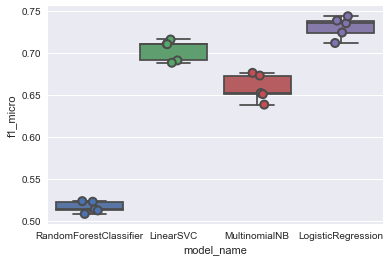

model_name
LinearSVC                 0.703404
LogisticRegression        0.730820
MultinomialNB             0.658261
RandomForestClassifier    0.516199
Name: f1_micro, dtype: float64

In [21]:
aux.model_eval(total_cv_df, ylabel='f1_micro')

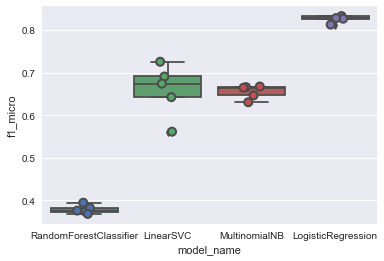

model_name
LinearSVC                 0.659124
LogisticRegression        0.826639
MultinomialNB             0.655227
RandomForestClassifier    0.379120
Name: f1_micro, dtype: float64

In [22]:
aux.model_eval(class_cv_df)

## Example of splitting the data into train and test sets with stratified class sampling

'total x shape: (3611,)'

'total y shape: (3611,)'

'train X shape with 1/2 samples: (1806, 4516)'

'train y shape: (1806,)'

'train X shape with 1/2 samples: (1805, 4516)'

'test y shape: (1805,)'

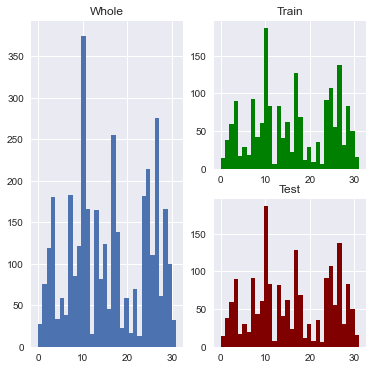

In [23]:
aux.example_split(X=x_txt, y=y_num, folds=2)

# Model Parameter Searches

## Actual Train/Test Split and Preparation

In [24]:
skf = StratifiedKFold(n_splits=FOLDS)
for train_index, test_index in skf.split(x_txt, y_num):
    X_train, X_test = x_txt[train_index], x_txt[test_index]
    y_train, y_test = y_num[train_index], y_num[test_index]
# only actually using the last set of indices
train_vocab, train_class_vocab = aux.build_vocab_word_counts(X_train, y_train)
X_train_num, X_train_lens = aux.txt_to_total_num(X_train, train_vocab)
X_test_num, X_test_lens = aux.txt_to_total_num(X_test, train_vocab)

In [25]:
display(f'total x shape: {x_txt.shape}')
display(f'total y shape: {y_num.shape}')
display(f'train X shape with {FOLDS-1}/{FOLDS} samples: {X_train_num.shape}')
display(f'train y shape: {y_train.shape}')
display(f'test X shape with 1/{FOLDS} samples: {X_test_num.shape}')
display(f'test y shape: {y_test.shape}')

'total x shape: (3611,)'

'total y shape: (3611,)'

'train X shape with 9/10 samples: (3250, 5955)'

'train y shape: (3250,)'

'test X shape with 1/10 samples: (361, 5955)'

'test y shape: (361,)'

In [42]:
for i in range(32):
    print(f'There are {len(train_class_vocab[i])} unique tokenized words for class {i} vocabulary')

There are 446 unique tokenized words for class 0 vocabulary
There are 1018 unique tokenized words for class 1 vocabulary
There are 1324 unique tokenized words for class 2 vocabulary
There are 1847 unique tokenized words for class 3 vocabulary
There are 397 unique tokenized words for class 4 vocabulary
There are 481 unique tokenized words for class 5 vocabulary
There are 510 unique tokenized words for class 6 vocabulary
There are 763 unique tokenized words for class 7 vocabulary
There are 1274 unique tokenized words for class 8 vocabulary
There are 1093 unique tokenized words for class 9 vocabulary
There are 1230 unique tokenized words for class 10 vocabulary
There are 1539 unique tokenized words for class 11 vocabulary
There are 265 unique tokenized words for class 12 vocabulary
There are 1722 unique tokenized words for class 13 vocabulary
There are 1053 unique tokenized words for class 14 vocabulary
There are 1275 unique tokenized words for class 15 vocabulary
There are 667 unique tok

In [26]:
X_train_nums_df = pd.DataFrame(data=X_train_num, columns=train_vocab.keys())
display(X_train_nums_df)
X_test_nums_df = pd.DataFrame(data=X_test_num, columns=train_vocab.keys())
display(X_test_nums_df)

,event,licensor,grant,another,vod,pay,per,view,ppv,service,...,questioning,vendee,affirm,selector,ani,acl,derivation,descriptive,propriety,acquit
0,1.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,event,licensor,grant,another,vod,pay,per,view,ppv,service,...,questioning,vendee,affirm,selector,ani,acl,derivation,descriptive,propriety,acquit
0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Classifier

In [27]:
if os.path.exists(rfc_pkl):
    rfc_df = pd.read_pickle(rfc_pkl)
    best_loc = np.nanargmax(rfc_df['mean_test'])
    print(f'Best: {rfc_df["mean_test"][best_loc]:.3f} (+/-{rfc_df["2xstd_test"][best_loc] * 2:.3f}) for {rfc_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(rfc_df.sort_values(by='mean_test', ascending=False))
else:
    rfc_grid_search = aux.model_search(X_train_num, y_train, model='rfc', seed=SEED, folds=FOLDS)
    aux.display_search_results(rfc_grid_search, filename=rfc_pkl)
    

Best: 0.653 (+/-0.097) for {'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': 0.6, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}


,mean_test,2xstd_test,mean_train,2xstd_train,params
287,0.652604,0.048647,0.893981,0.013346,"{'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': None, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}"
286,0.652604,0.048647,0.893981,0.013346,"{'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}"
285,0.652604,0.048647,0.893981,0.013346,"{'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': 0.9, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}"
284,0.652604,0.048647,0.893981,0.013346,"{'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': 0.6, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}"
275,0.649479,0.045655,0.893519,0.014521,"{'rfc__bootstrap': False, 'rfc__max_depth': 17, 'rfc__max_samples': 0.6, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 500}"
...,...,...,...,...,...
20,0.303125,0.137073,0.376736,0.038005,"{'rfc__bootstrap': False, 'rfc__max_depth': 3, 'rfc__max_samples': 0.9, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 500}"
29,0.303125,0.137073,0.376736,0.038005,"{'rfc__bootstrap': False, 'rfc__max_depth': 3, 'rfc__max_samples': None, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 500}"
5,0.303125,0.137073,0.376389,0.037326,"{'rfc__bootstrap': False, 'rfc__max_depth': 3, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 500}"
23,0.303125,0.137073,0.376389,0.037326,"{'rfc__bootstrap': False, 'rfc__max_depth': 3, 'rfc__max_samples': 0.9, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 500}"


0.8403076923076923


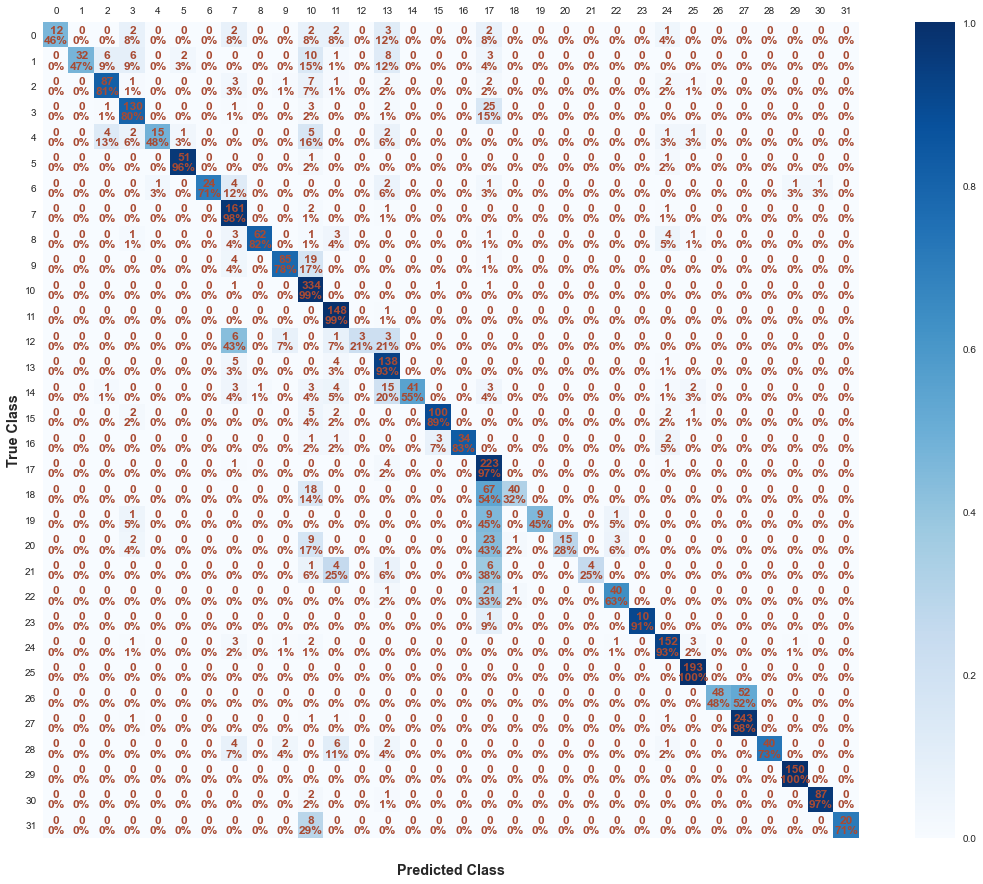

In [28]:
if os.path.exists(rfc_model):
    best_rfc = load(rfc_model)
else:
    best_rfc = RandomForestClassifier(random_state=SEED, bootstrap=False, 
          max_depth=17, max_samples=0.6, min_samples_split=8, n_estimators=300)
    best_rfc.fit(X_train_num, y_train)
    dump(best_rfc, rfc_model)
y_train_pred_rfc = best_rfc.predict(X_train_num)
print(best_rfc.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_rfc)

## Logistic Regression

In [29]:
if os.path.exists(logreg_pkl):
    logreg_df = pd.read_pickle(logreg_pkl)
    best_loc = np.nanargmax(logreg_df['mean_test'])
    print(f'Best: {logreg_df["mean_test"][best_loc]:.3f} (+/-{logreg_df["2xstd_test"][best_loc] * 2:.3f}) for {logreg_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(logreg_df.sort_values(by='mean_test', ascending=False))
else:
    logreg_grid_search = aux.model_search(X_train_num, y_train, model='logreg', seed=SEED, folds=FOLDS)
    aux.display_search_results(logreg_grid_search, filename=logreg_pkl)

Best: 0.706 (+/-0.123) for {'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}


,mean_test,2xstd_test,mean_train,2xstd_train,params
15,0.705729,0.061670,0.950116,0.023893,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
12,0.705208,0.075433,0.973669,0.006833,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
14,0.705208,0.075433,0.973669,0.006833,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
13,0.705208,0.057848,0.917130,0.037657,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
11,0.637500,0.081250,0.977083,0.024689,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
2,0.635938,0.062578,0.990972,0.011495,"{'logreg__max_iter': 100, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
6,0.635938,0.062578,0.990972,0.011495,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
7,0.635938,0.077875,0.947569,0.061954,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
10,0.635938,0.062578,0.990972,0.011495,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
1,0.623437,0.075842,0.990972,0.011495,"{'logreg__max_iter': 100, 'logreg__multi_class': 'auto', 'logreg__solver': 'lbfgs'}"


0.9190769230769231


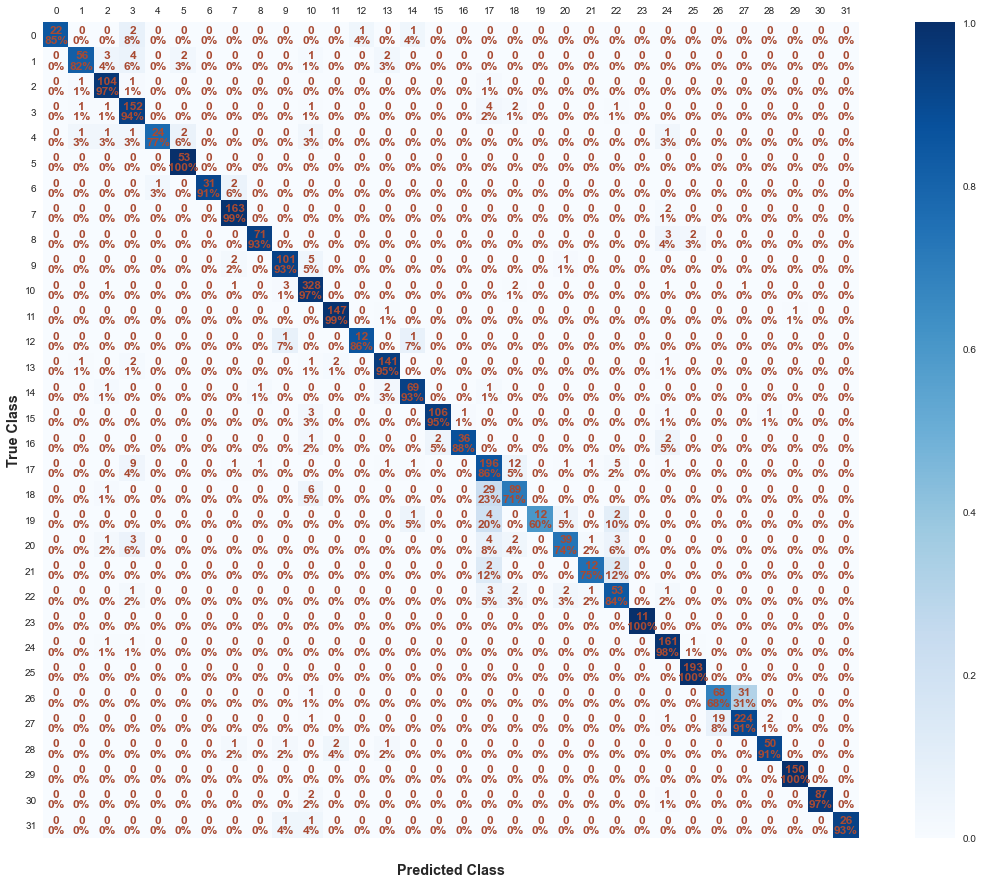

In [30]:
if os.path.exists(logreg_model):
    best_logreg = load(logreg_model)
else:
    best_logreg = LogisticRegression(random_state=SEED, max_iter=500, multi_class='auto', solver='sag')
    best_logreg.fit(X_train_num, y_train)
    dump(best_logreg, logreg_model)
y_train_pred_logreg = best_logreg.predict(X_train_num)
print(best_logreg.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_logreg)

## Multinomial Naive Bayes

In [31]:
if os.path.exists(mnb_pkl):
    mnb_df = pd.read_pickle(mnb_pkl)
    best_loc = np.nanargmax(mnb_df['mean_test'])
    print(f'Best: {mnb_df["mean_test"][best_loc]:.3f} (+/-{mnb_df["2xstd_test"][best_loc] * 2:.3f}) for {mnb_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(mnb_df.sort_values(by='mean_test', ascending=False))
else:
    mnb_grid_search = aux.model_search(X_train_num, y_train, model='mnb', seed=SEED, folds=FOLDS)
    aux.display_search_results(mnb_grid_search, filename=mnb_pkl)

Best: 0.637 (+/-0.126) for {'mnb__alpha': 0.34}


,mean_test,2xstd_test,mean_train,2xstd_train,params
113,0.636979,0.062855,0.879398,0.013056,{'mnb__alpha': 0.34}
102,0.636458,0.063840,0.877141,0.010796,{'mnb__alpha': 0.36}
122,0.636458,0.067636,0.881250,0.012236,{'mnb__alpha': 0.33}
101,0.636458,0.062812,0.875521,0.010537,{'mnb__alpha': 0.37}
111,0.636458,0.065352,0.882465,0.012492,{'mnb__alpha': 0.32}
...,...,...,...,...,...
96,0.543750,0.100584,0.813368,0.033494,{'mnb__alpha': 0.96}
97,0.543750,0.100584,0.811806,0.032801,{'mnb__alpha': 0.97}
99,0.542188,0.101791,0.809896,0.031375,{'mnb__alpha': 0.99}
98,0.542188,0.101791,0.811111,0.032080,{'mnb__alpha': 0.98}


0.8443076923076923


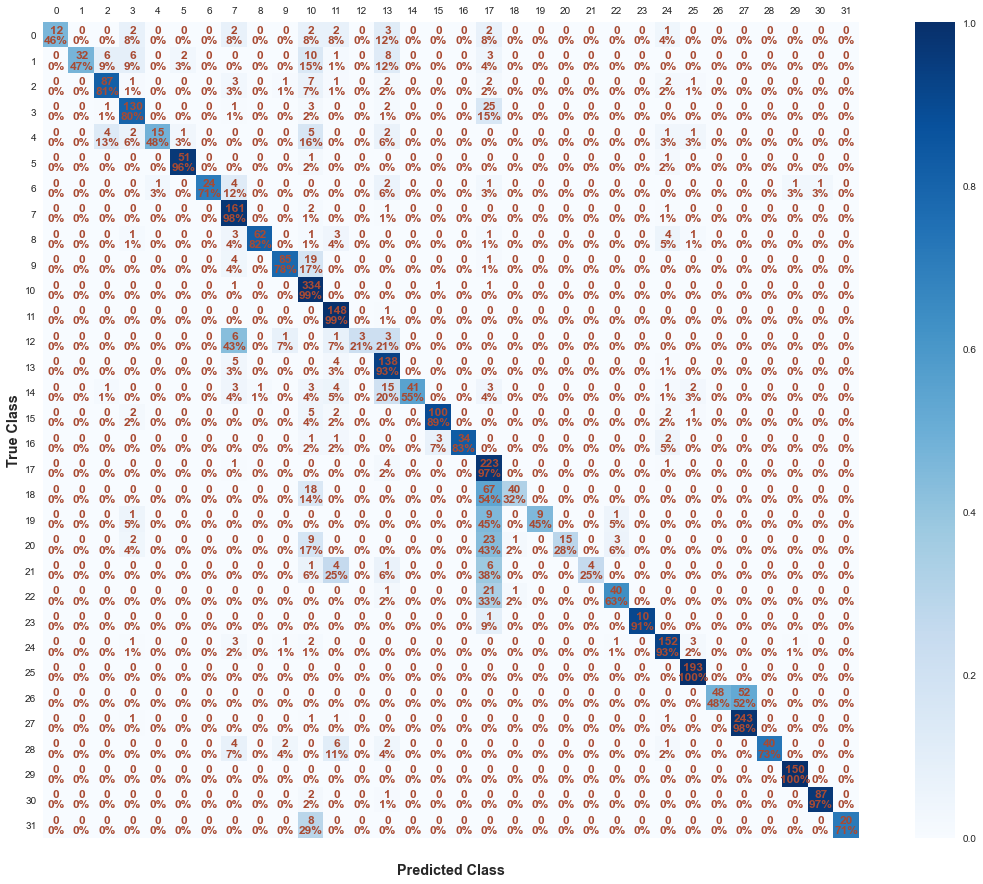

In [32]:
if os.path.exists(mnb_model):
    best_mnb = load(mnb_model)
else:
    best_mnb = MultinomialNB(alpha=0.34)
    best_mnb.fit(X_train_num, y_train)
    dump(best_mnb, mnb_model)
y_train_pred_mnb = best_rfc.predict(X_train_num)
print(best_mnb.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_mnb)

# Comparing the Best Models

Reminder of Class Distributions:


,Class,Train Counts,Test Counts,Total Counts
Most Favored Nation,0,26,2,28
Competitive Restriction Exception,1,68,8,76
Non-Compete,2,107,12,119
Exclusivity,3,162,18,180
No-Solicit Of Customers,4,31,3,34
No-Solicit Of Employees,5,53,6,59
Non-Disparagement,6,34,4,38
Termination For Convenience,7,165,18,183
Rofr/Rofo/Rofn,8,76,9,85
Change Of Control,9,109,12,121


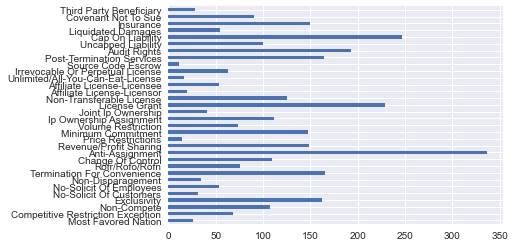

In [33]:
print('Reminder of Class Distributions:')
train_ct = aux.class_count(y_train, 32)
test_ct = aux.class_count(y_test, 32)
df_classes = pd.DataFrame(data={'Class': np.arange(32),
    'Train Counts': train_ct, 'Test Counts': test_ct,
    'Total Counts': df_01_ans.astype(bool).sum(axis=0)},)
display(df_classes)
df_classes['Train Counts'].plot.barh()
if not os.path.exists(class_counts):
    df_classes.to_csv(class_counts)

In [34]:
print(f'F1 micro-averaged score of optimized RFC model with test data: {best_rfc.score(X_test_num, y_test)}')
# print(f'F1 score of optimized RFC model with test data: {f1_score(y_test, y_test_pred_rfc, average="micro")}')
print(f'F1 micro-averaged score of optimized LogReg model with test data: {best_logreg.score(X_test_num, y_test)}')
print(f'F1 micro-averaged score of optimized Multinomial NB model with test data: {best_mnb.score(X_test_num, y_test)}')
optimized_scores = [best_rfc.score(X_test_num, y_test), best_mnb.score(X_test_num, y_test), best_logreg.score(X_test_num, y_test)]
model_names = ['Random Forest Classifier', 'Multinomial Naive Bayes', 'Logistic Regression']
model_params = [best_rfc.get_params(), best_mnb.get_params(), best_logreg.get_params()]
opt_data = {'Model Name': model_names, 'Model Parameters': model_params, 'F1 Micro-Averaged Test Scores': optimized_scores}
optimized_df = pd.DataFrame(data=opt_data, columns=['Model Name', 'Model Parameters', 'F1 Micro-Averaged Test Scores'])
display(optimized_df)
if not os.path.exists(opt_csv):
    optimized_df.to_csv(opt_csv)

F1 micro-averaged score of optimized RFC model with test data: 0.6509695290858726
F1 micro-averaged score of optimized LogReg model with test data: 0.739612188365651
F1 micro-averaged score of optimized Multinomial NB model with test data: 0.6759002770083102


,Model Name,Model Parameters,F1 Micro-Averaged Test Scores
0,Random Forest Classifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.650970
1,Multinomial Naive Bayes,"{'alpha': 0.34, 'class_prior': None, 'fit_prio...",0.675900
2,Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.739612


In [35]:
best_logreg2 = LogisticRegression(random_state=SEED, max_iter=250, multi_class='auto', solver='liblinear')
best_logreg2.fit(X_train_num, y_train)
y_train_pred_logreg2 = best_logreg2.predict(X_train_num)
print(best_logreg2.score(X_train_num, y_train))
# aux.show_conf_matrix(y_train, y_train_pred_logreg2)
y_test_pred_logreg2 = best_logreg2.predict(X_test_num)
print(f'Best LogReg model 2 with test data: {best_logreg2.score(X_test_num, y_test)}')

0.9544615384615385
Best LogReg model 2 with test data: 0.7506925207756233


In [36]:
# fig, ax = plt.subplots(figsize=(16, 16))
# ax.set_xlabel('Predicted Class', fontsize='x-large', fontweight='bold', labelpad=25)
# ax.set_ylabel('True Class', fontsize='x-large', fontweight='bold')
# plot_confusion_matrix(best_rfc, X_test_num, y_test, cmap=plt.cm.Blues, ax=ax)
# plt.grid(None)
# plt.show()

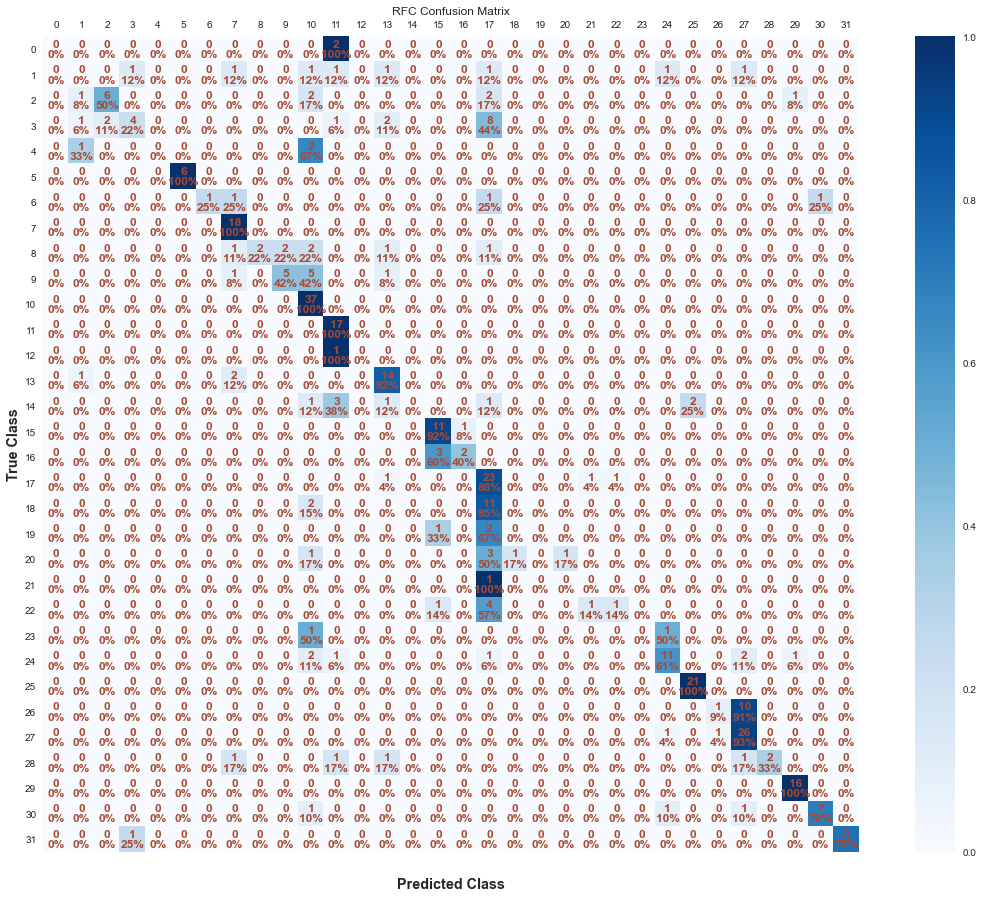

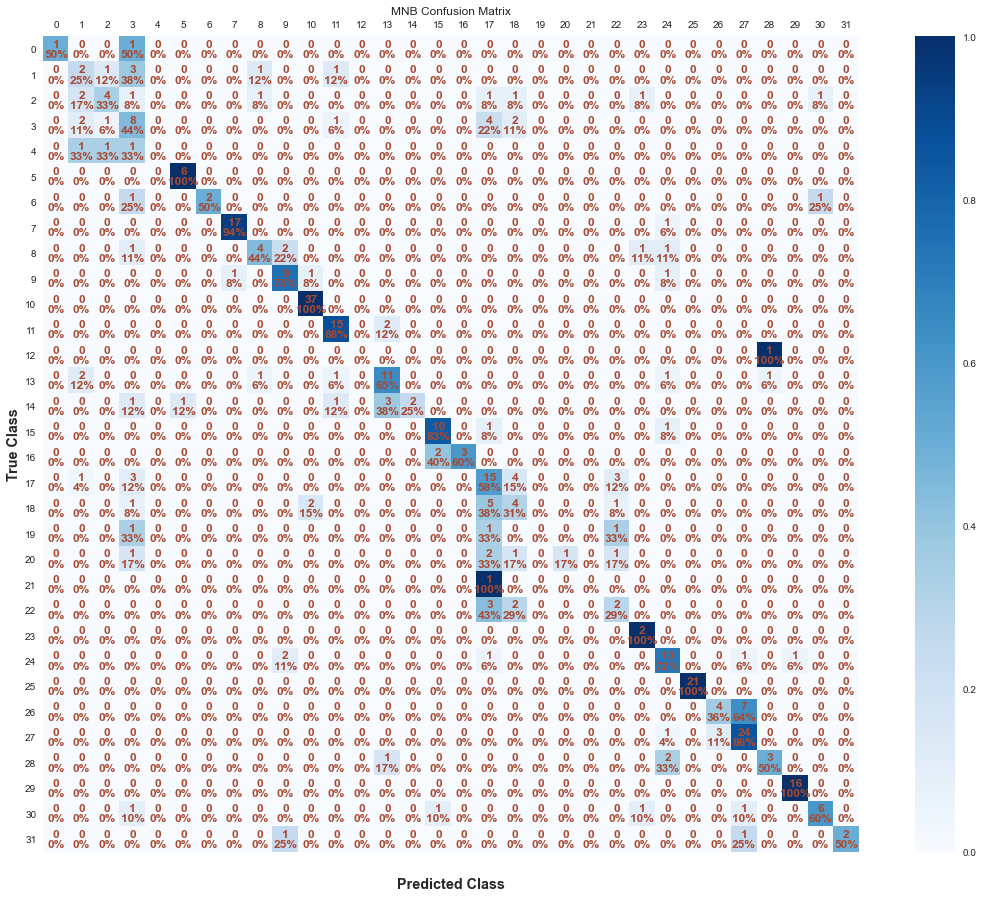

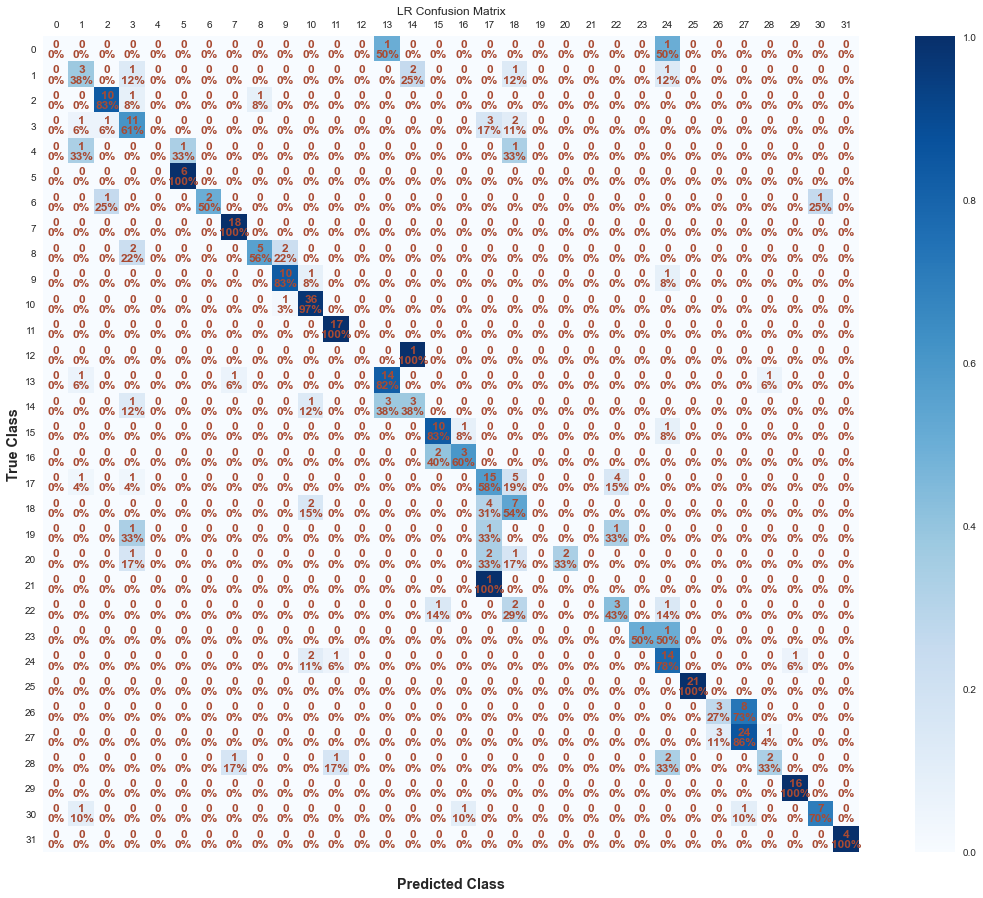

In [40]:
y_test_pred_rfc = best_rfc.predict(X_test_num)
y_test_pred_mnb = best_mnb.predict(X_test_num)
y_test_pred_logreg = best_logreg.predict(X_test_num)
aux.show_conf_matrix(y_test, y_test_pred_rfc, title='RFC Confusion Matrix', file='rfc_conf.jpg')
aux.show_conf_matrix(y_test, y_test_pred_mnb, title='MNB Confusion Matrix', file='mnb_conf.jpg')
aux.show_conf_matrix(y_test, y_test_pred_logreg, title='LR Confusion Matrix', file='lr_conf.jpg')

C:\Users\raind\WORK\AFIT\21SP\CSCE623\Project\auxiliary.py:500: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mx = conf_mx / row_sums  # np.max(conf_mx) #row_sums


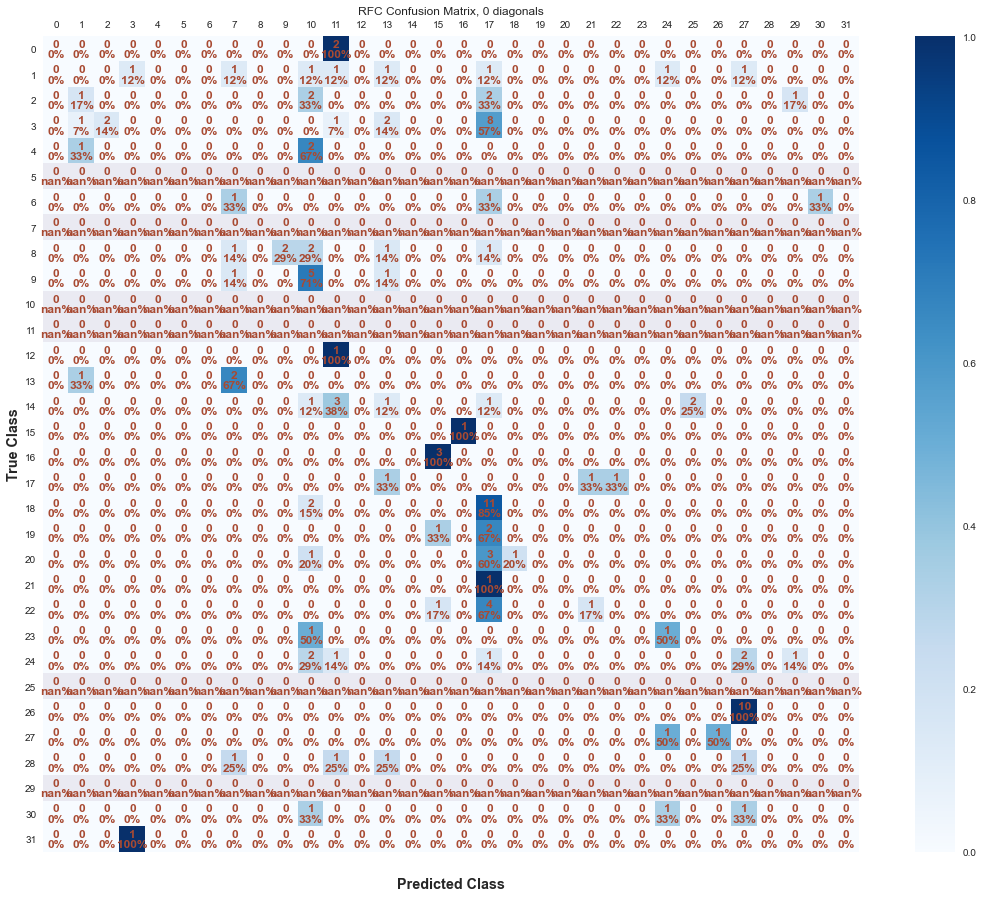

C:\Users\raind\WORK\AFIT\21SP\CSCE623\Project\auxiliary.py:500: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mx = conf_mx / row_sums  # np.max(conf_mx) #row_sums


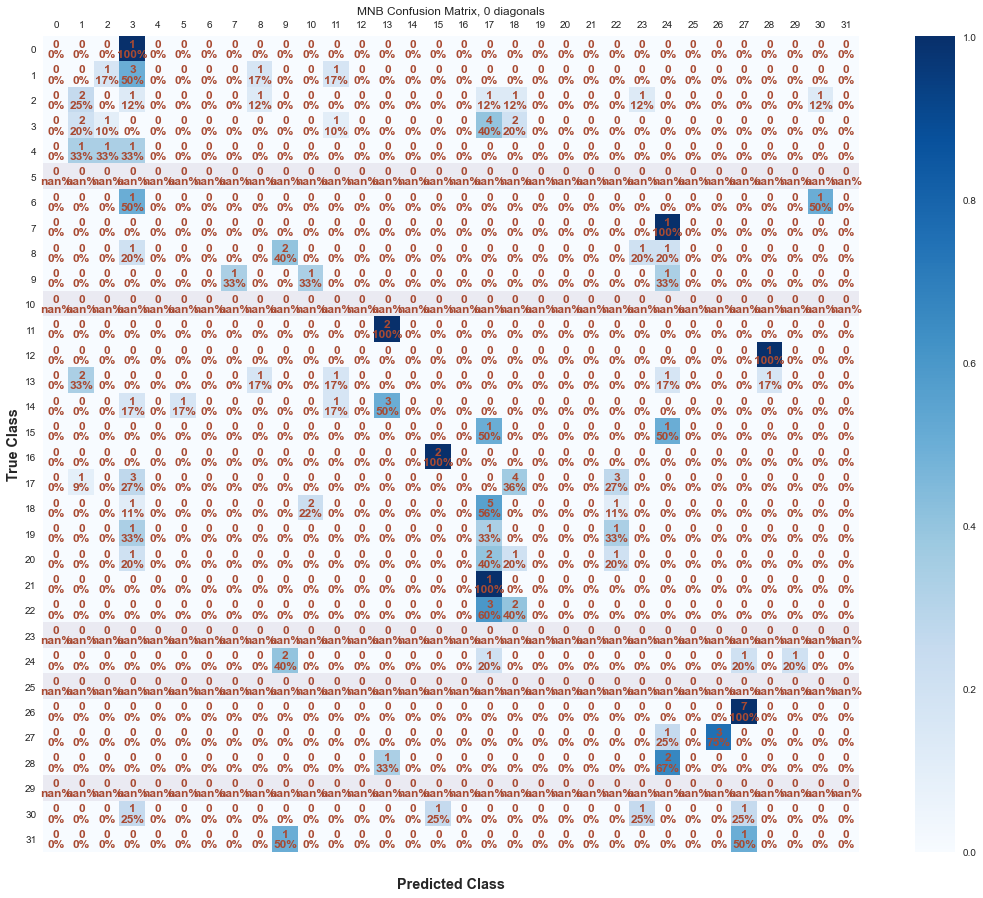

C:\Users\raind\WORK\AFIT\21SP\CSCE623\Project\auxiliary.py:500: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mx = conf_mx / row_sums  # np.max(conf_mx) #row_sums


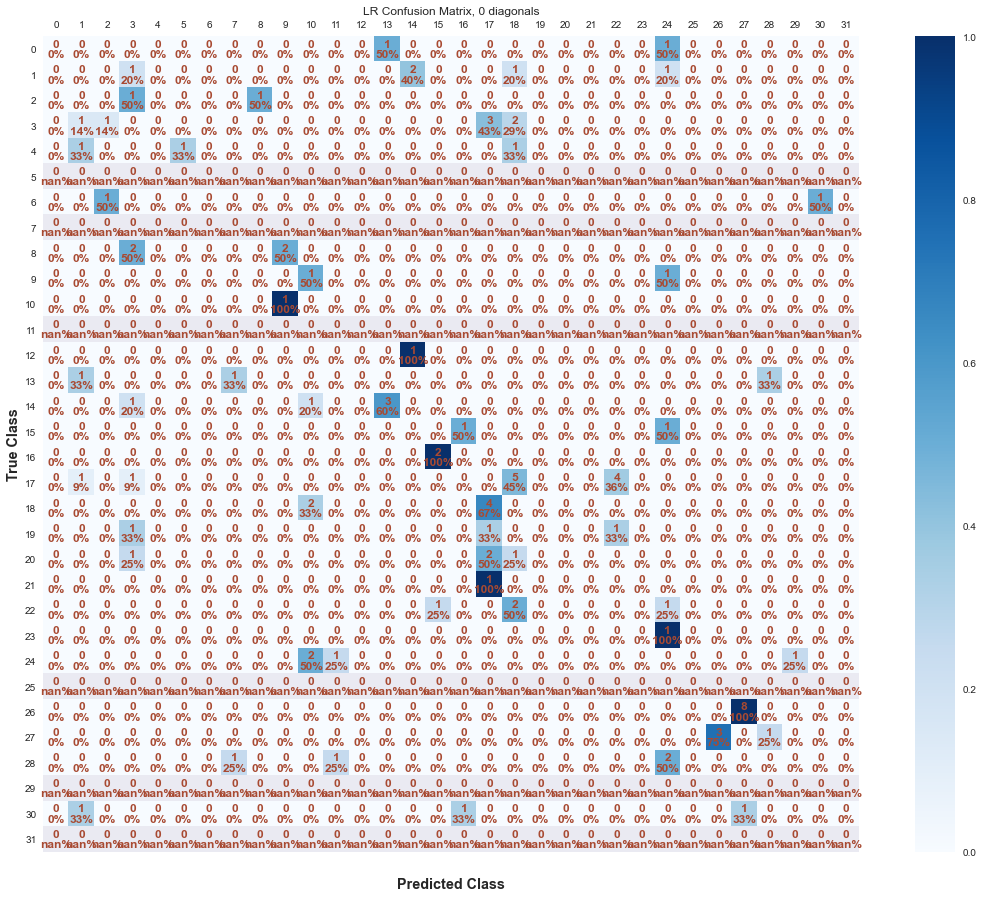

In [41]:
aux.show_conf_matrix(y_test, y_test_pred_rfc, title='RFC Confusion Matrix, 0 diagonals', zero_diag=True, file='rfc_conf_err.jpg')
aux.show_conf_matrix(y_test, y_test_pred_mnb, title='MNB Confusion Matrix, 0 diagonals', zero_diag=True, file='mnb_conf_err.jpg')
aux.show_conf_matrix(y_test, y_test_pred_logreg, title='LR Confusion Matrix, 0 diagonals', zero_diag=True, file='lr_conf_err.jpg')

In [ ]:
# aux.visualize_rf(best_rfc, YN_TXT_COLS)

# RELOAD

In [ ]:
# run this to update the auxiliary import after making changes
reload(aux)

# EOF